In [1]:
import os, math
from enum import StrEnum, auto
from collections import defaultdict, namedtuple, Counter
import itertools
import sqlite3
import pickle
import datetime
import multiprocessing as mp
import gc
import json
from IPython.core.getipython import get_ipython

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()
mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, 'fork' method leads to failures in bootstrap somewhere around CUDA

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

with open(get_ipython().kernel.config['IPKernelApp']['connection_file'], 'r') as cf:
    notebook_fname = json.load(cf)['jupyter_session']
    notebook_fname = os.path.basename(notebook_fname)

print(notebook_fname)

hdc = Hdc(10_000, xp)

xp = numpy
transf_learn.ipynb


In [3]:
%run sequencing_sp2.ipynb

# Open DB

In [4]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))
test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)

if not DBUtils.is_table_exists(test_results_db_con, 'test_runs'):
    test_results_db_con.execute('CREATE TABLE test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.58 μs


((10000, 7), (2000, 7))


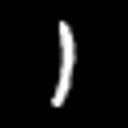
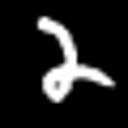
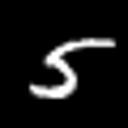
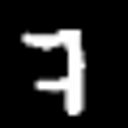
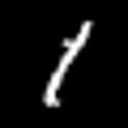
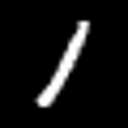
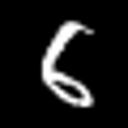
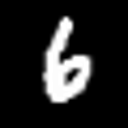
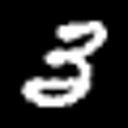
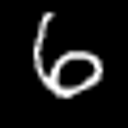
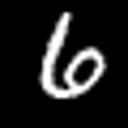
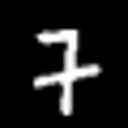
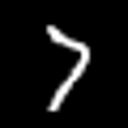
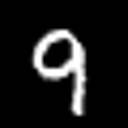
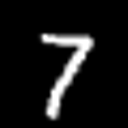
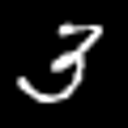

In [5]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Hyper Parameters

In [6]:
HP_SIGNAL_VEC_LEN = 1024
HP_COMBI_SPACE_SIZE = int(np.sqrt(HP_SIGNAL_VEC_LEN))
HP_CLUSTER_SIGNALS_PROCESSED_THRES = 50
HP_CLUSTER_STATS_LEN_THRES = 10
HP_CLUSTER_ACCURACY_THRES = 0.75
HP_CLUSTER_BINARIZE_THRES = 0.75
HP_POINTS_COUNT = 5000
HP_POINT_NON_ZERO_BITS = 100

assert HP_COMBI_SPACE_SIZE ** 2 == HP_SIGNAL_VEC_LEN

## Types

In [7]:
class ClusterState(StrEnum):
    LEARN = auto()
    PREPROD = auto()
    PROD = auto()

class ClusterMeta:
    def __init__(self, cluster_ind, cluster_key, output_bit, nu, cycle):
        self.state = ClusterState.LEARN
        self.cluster_ind = cluster_ind
        self.cluster_key = cluster_key
        self.output_bit = output_bit
        self.nu = nu
        self.cycle = cycle
        self.ones_count = 0
        self.signals_processed = 0
        self.stats = Counter()
        self.verify_image_ids = {}

## Memory

In [8]:
CLUSTERS = HdvArray(HP_COMBI_SPACE_SIZE ** 2, xp, dtype='f')
CLUSTER_MASKS = HdvArray(HP_COMBI_SPACE_SIZE ** 2, xp, dtype='f')

CLUSTER_KEY_TO_CLUSTER_IND = {} # key - cluster key (i.e. pair (output_bit, tuple(input_bits))), value - cluster ind

CLUSTER_METAS = {} # key - cluster index, value ClusterMeta instance

In [9]:
def gc_memory():
    gc.collect()
    
    if cp.cuda.is_available():
        cp.get_default_memory_pool().free_all_blocks()

def clear_memory(with_caches=False):
    CLUSTER_KEY_TO_CLUSTER_IND.clear()
    CLUSTER_METAS.clear()
    CLUSTER_MASKS.clear()
    CLUSTERS.clear()
    
    if with_caches:
        pass
    
    gc_memory()

## Combinatorial Space (CS)

In [10]:
%%time
POINTS = []
POINT_OUTPUT_BITS = []
output_bits = RNG.choice(HP_SIGNAL_VEC_LEN, HP_POINTS_COUNT)

for output_bit in output_bits:
    point_vec = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
    non_zero_inds = RNG.choice(HP_SIGNAL_VEC_LEN, HP_POINT_NON_ZERO_BITS, replace=False)
    point_vec[non_zero_inds] = 1
    POINTS.append(point_vec)
    POINT_OUTPUT_BITS.append(output_bit)

POINTS = xp_array_to_gpu(np.vstack(POINTS))
POINT_OUTPUT_BITS = np.hstack(POINT_OUTPUT_BITS)
POINT_INDS = np.arange(POINTS.shape[0])

CPU times: user 43.3 ms, sys: 10 ms, total: 53.4 ms
Wall time: 53 ms


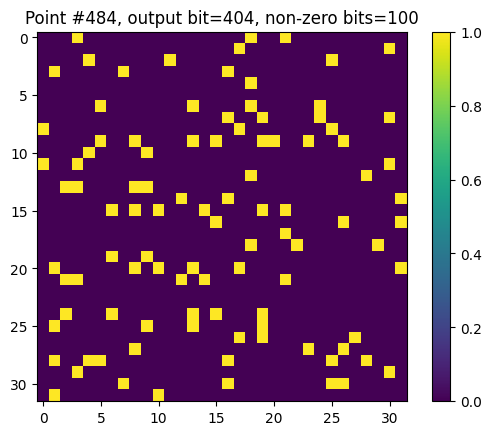

In [11]:
point_ind = RNG.choice(POINTS.shape[0])
point = POINTS[point_ind]
plt.imshow(xp_array_from_gpu(point.reshape(HP_COMBI_SPACE_SIZE, -1)))
plt.title(f'Point #{point_ind}, output bit={POINT_OUTPUT_BITS[point_ind]}, non-zero bits={point.sum():.0f}')
plt.colorbar();

## lambdas

In [12]:
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_sequences_reading = lambda sequences, seq_reading_code: list(map(lambda r: sequences[r[0]] if r[1] == 0 else list(reversed(sequences[r[0]])), seq_reading_code))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))
get_raw_image = lambda image_id: Image.open(io.BytesIO((df_train_images if image_id < 100_000_000 else df_test_images).loc[image_id]['png']))
get_cluster_key = lambda output_bit, input_bits: (int(output_bit), tuple(map(int, sorted(input_bits))))
signal_elem_ind_to_xy = lambda ind: (int(ind % HP_COMBI_SPACE_SIZE), int(ind // HP_COMBI_SPACE_SIZE))
signal_elem_inds_to_xy = lambda inds: list(map(lambda ind: signal_elem_ind_to_xy(ind), inds))
get_cluster_logic = lambda cluster_ind: (signal_elem_inds_to_xy(xp_array_from_gpu(xp.argwhere(CLUSTERS.array_active[cluster_ind]).ravel()).astype('i')), signal_elem_ind_to_xy(CLUSTER_METAS[cluster_ind].output_bit))

## calc_seq_ipxy

In [13]:
def calc_seq_ipxy(sequences, si_ind_dict):
    res = []  # transcript of sequences with full interpolation by xy 
        
    for sequence in sequences:
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence_fwd = np.roll(xy_sequence, -1, axis=0)
        vec_sequence = xy_sequence_fwd - xy_sequence
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        vec_len_sequence = np.round(vec_len_sequence, decimals=0).astype(int)
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        for pt, pt_to, norm_vec, vec_len in zip(xy_sequence, xy_sequence_fwd, norm_vec_sequence, vec_len_sequence):
            if vec_len <= 0:
                continue

            pts = pt + (np.arange(vec_len) * norm_vec[np.newaxis,:].T).T # path interpolation
            pts = np.round(pts, decimals=0).astype(int)
            res.append(pts)
            res.append(pt_to)

    assert res
    res = np.vstack(res)
    return res

## calc_seq_bv

In [14]:
def calc_seq_bv(seq_xy):
    seq_xy = xp_array_to_gpu(seq_xy)
    seq_xy = seq_xy * (HP_COMBI_SPACE_SIZE / config.sample_size)
    # Leave only points which fit into square defined by HP_COMBI_CLUSTERS_SPACE_SIZE,
    # use filtering instead of clipping because clipping tends to introduce false point clustering at the bounadries
    seq_xy = xp.round(seq_xy, decimals=0)
    ii = xp.all(((seq_xy >= 0) & (seq_xy < HP_COMBI_SPACE_SIZE)), axis=1) 
    seq_xy = seq_xy[ii]
    ind_seq = (seq_xy @ xp.array([1, HP_COMBI_SPACE_SIZE])).astype(int)
    bitmap_vec = xp.zeros((HP_COMBI_SPACE_SIZE, HP_COMBI_SPACE_SIZE), dtype='f').ravel()
    bitmap_vec[ind_seq] = 1
    return bitmap_vec

## get_seq_bv_pair

In [15]:
def get_seq_bv_pair(df_image, transf):
    si_ind_dict = pickle.loads(df_image.inner_si_ind_dict)
    sequences = pickle.loads(df_image.inner_sequences)
    seq_reading_code = tuple(zip(range(len(sequences)), (0,) * len(sequences)))
    seq_reading = get_sequences_reading(sequences, seq_reading_code)
    seq_ipxy = calc_seq_ipxy(seq_reading, si_ind_dict)
    seq_bv = calc_seq_bv(seq_ipxy)

    seq_ipxy_transf = np.hstack([seq_ipxy, np.ones(seq_ipxy.shape[0])[:,np.newaxis]]) # make homogeneous coords
    seq_ipxy_transf = (transf @ seq_ipxy_transf.T).T[:,:2]
    seq_bv_transf = calc_seq_bv(seq_ipxy_transf)
    
    return seq_bv, seq_bv_transf

## .lab

# Train

In [16]:
move_to_ooc_transf = np.array([
    [1, 0, -config.sample_size / 2],
    [0, 1, -config.sample_size / 2],
    [0, 0, 1]])
theta = np.deg2rad(45)
cos_theta = math.cos(theta)
sin_theta = math.sin(theta)
rotation_transf = np.array([
    [cos_theta, -sin_theta, 0],
    [sin_theta, cos_theta, 0],
    [0, 0, 1]
])
move_to_target_loc_transf = np.array([
    [1, 0, config.sample_size / 2],
    [0, 1, config.sample_size / 2],
    [0, 0, 1]])
transf_rot45 = move_to_target_loc_transf @ rotation_transf @ move_to_ooc_transf

In [17]:
transf_offset = np.array([
    [1, 0, 10],
    [0, 1, 0],
    [0, 0, 1]])

In [18]:
# TRANSF = transf_rot45
TRANSF = transf_offset

In [19]:
LOG.is_enabled = True

In [20]:
clear_memory(with_caches=True)

In [22]:
cycle_images_count = min(100, len(df_train_images))
cycles_count = 10

In [23]:
# %%time
prod_cluster_metas = list(filter(lambda c: c.state == ClusterState.PROD, CLUSTER_METAS.values()))
unique_prod_cluster_keys = set(map(lambda m: get_cluster_key(m.output_bit, np.argwhere(CLUSTERS.array_active[m.cluster_ind]).ravel()), prod_cluster_metas))

for cycle in tqdm(range(cycles_count), desc='Cycle'):
    cycle_image_ids = RNG.choice(df_train_images.index, cycle_images_count, replace=False).astype('i')
    # cycle_image_ids = [52523]
    df_cycle_images = df_train_images.loc[cycle_image_ids]

    ###
    signals_input = []
    signals_output = []
    
    for image_ind, image in tqdm(enumerate(df_cycle_images.itertuples()), total=len(df_cycle_images), leave=False, desc='Prepare signals'):
        seq_bv_origin, seq_bv_transf = get_seq_bv_pair(image, TRANSF)
        signals_input.append(seq_bv_origin)
        signals_output.append(seq_bv_transf)

    signals_input = xp.vstack(signals_input)
    signals_output = xp_array_from_gpu(xp.vstack(signals_output))

    ###
    for signal_input, signal_output in tqdm(zip(signals_input, signals_output), total=signals_input.shape[0], leave=False, desc='Create clusters'):
        active_points_mask = signal_output[POINT_OUTPUT_BITS] != 0
        active_point_inds = POINT_INDS[active_points_mask]
        assert active_point_inds.shape[0] > 0
        active_points = POINTS[active_point_inds] # subset of POINTS which are connected with active output bits
        active_points_signal_input_mat = active_points * signal_input
        active_points_signal_input_mask = xp.any(active_points_signal_input_mat, axis=1) # which of active_points have any ON bits within input signal?
        active_points_signal_input_mask = xp_array_from_gpu(active_points_signal_input_mask)

        for point_ind, subsignal_input, subsignal_input_gpu in zip(active_point_inds[active_points_signal_input_mask], 
                                                                   xp_array_from_gpu(active_points_signal_input_mat[active_points_signal_input_mask]),
                                                                   active_points_signal_input_mat[active_points_signal_input_mask]):
            active_output_bit = int(POINT_OUTPUT_BITS[point_ind])
            active_input_bits = np.argwhere(subsignal_input).ravel()
            cluster_key = get_cluster_key(active_output_bit, active_input_bits)

            if cluster_key in CLUSTER_KEY_TO_CLUSTER_IND:
                continue

            cluster_ind = CLUSTERS.lease()
            cluster_mask_ind = CLUSTER_MASKS.lease()
            assert cluster_ind == cluster_mask_ind
            CLUSTERS.array_active[cluster_ind] = subsignal_input_gpu
            CLUSTER_MASKS.array_active[cluster_ind] = subsignal_input_gpu
            cluster_meta = ClusterMeta(cluster_ind=cluster_ind, cluster_key=cluster_key, output_bit=active_output_bit, nu=1/subsignal_input.sum(), cycle=cycle)
            CLUSTER_METAS[cluster_ind] = cluster_meta
            CLUSTER_KEY_TO_CLUSTER_IND[cluster_key] = cluster_ind

    ###
    learn_cluster_metas = list(filter(lambda c: c.state == ClusterState.LEARN, CLUSTER_METAS.values()))
    learn_cluster_inds = np.array(list(map(lambda c: c.cluster_ind, learn_cluster_metas)), dtype='i')
    learn_cluster_output_bits = np.array(list(map(lambda c: c.output_bit, learn_cluster_metas)), dtype='i')
    
    for signal_input, signal_output in tqdm(zip(signals_input, signals_output), total=signals_input.shape[0], leave=False, desc='Learn clusters'):
        # this stanza 'signal_output[learn_cluster_output_bits] != 0' effectively produces
        # boolean mask for learn_cluster_inds - clusters which are connected to currently active output bits
        active_cluster_inds = learn_cluster_inds[signal_output[learn_cluster_output_bits] != 0]

        if active_cluster_inds.shape[0] == 0:
            continue
        
        active_clusters = CLUSTERS.array_active[active_cluster_inds] # subset of CLUSTERS which are connected to active bits in signal_output
        active_cluster_masks = CLUSTER_MASKS.array_active[active_cluster_inds]
        cluster_nus = xp.array(list(map(lambda cluster_ind: CLUSTER_METAS[cluster_ind].nu, active_cluster_inds)))

        ys = signal_input @ active_clusters.T # how each cluster reacted on signal_input, ca. shape (35,)
        grow = (signal_input * (cluster_nus * ys)[:,np.newaxis]) # how weights within each cluster must grow up in response co signal_input, matrix, ca. shape (35, 1024)
        grow *= active_cluster_masks # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 1024)
        nomins = active_clusters + grow # grow weights within clusters
        denoms = nomins.max(axis=1) 
        CLUSTERS.array_active[active_cluster_inds] = (nomins.T / denoms).T # upload new new weights

        for cluster_ind in active_cluster_inds:
            cluster_meta = CLUSTER_METAS[cluster_ind]
            cluster_meta.signals_processed += 1

    ### Promote LEARN clusters to PREPROD if they've learned enough
    cluster_metas_to_promote = list(filter(lambda c: c.state == ClusterState.LEARN and c.signals_processed > HP_CLUSTER_SIGNALS_PROCESSED_THRES, CLUSTER_METAS.values()))
    cluster_inds_to_promote = list(map(lambda c: c.cluster_ind, cluster_metas_to_promote))
    binarized_clusters = xp.where(CLUSTERS.array_active[cluster_inds_to_promote] > HP_CLUSTER_BINARIZE_THRES, 1, 0)
    binarized_clusters_ones_counts = binarized_clusters.sum(axis=1)
    CLUSTERS.array_active[cluster_inds_to_promote] = binarized_clusters
    
    for cluster_meta, ones_count in tqdm(zip(cluster_metas_to_promote, binarized_clusters_ones_counts), total=len(cluster_metas_to_promote), leave=False, desc='Promote clusters'):
        cluster_ind = cluster_meta.cluster_ind
        cluster_meta.ones_count = int(ones_count)
        assert cluster_meta.ones_count > 0
        cluster_meta.state = ClusterState.PREPROD

    ### Verify PREPROD cluster against new signals
    prod_cluster_metas = list(filter(lambda c: c.state == ClusterState.PREPROD, CLUSTER_METAS.values()))
    prod_cluster_inds = np.array(list(map(lambda c: c.cluster_ind, prod_cluster_metas)), dtype='i')
    prod_cluster_ones_counts = xp.array(list(map(lambda c: c.ones_count, prod_cluster_metas)), dtype='f')
    prod_cluster_output_bits = np.array(list(map(lambda c: c.output_bit, prod_cluster_metas)), dtype='i')
    prod_clusters = CLUSTERS.array_active[prod_cluster_inds]
    
    for signal_input, signal_output, signal_image_id in tqdm(zip(signals_input, signals_output, cycle_image_ids), 
                                                             total=signals_input.shape[0], leave=False, desc='Verify clusters'):
        activated_clusters_mask = xp_array_from_gpu((prod_clusters @ signal_input) >= prod_cluster_ones_counts)
        # cast array of output_bit numbers [0, 3, 4, 7, 7, 0, 3, 32, ..] to TP array [True, False, False, True, True, True, False, False, ...]
        # where True if output_bit of prod_cluster is enabled in signal_output and False otherwise
        prod_cluster_output_bits_tf = signal_output[prod_cluster_output_bits] != 0
        
        for cluster_ind, tf in zip(prod_cluster_inds[activated_clusters_mask], prod_cluster_output_bits_tf[activated_clusters_mask]):
            tf = bool(tf) # not mandatory, but eases further inspections by eyes
            signal_image_id = int(signal_image_id)
            cluster_meta = CLUSTER_METAS[cluster_ind]

            if not signal_image_id in cluster_meta.verify_image_ids:
                cluster_meta.stats[tf] += 1
                cluster_meta.verify_image_ids[signal_image_id] = tf

    ### 
    ready_for_prod_cluster_metas = list(filter(lambda c: c.state == ClusterState.PREPROD and c.stats.total() > HP_CLUSTER_STATS_LEN_THRES, CLUSTER_METAS.values()))
    accurate_ready_for_prod_cluster_metas = filter(lambda c: c.stats[True] / c.stats.total() >= HP_CLUSTER_ACCURACY_THRES, ready_for_prod_cluster_metas)
    unneeded_cluster_metas = list(filter(lambda c: c.stats[True] / c.stats.total() < HP_CLUSTER_ACCURACY_THRES, ready_for_prod_cluster_metas))
    
    for cluster_meta in accurate_ready_for_prod_cluster_metas:
        cluster_key_for_prod = get_cluster_key(cluster_meta.output_bit, np.argwhere(CLUSTERS.array_active[cluster_meta.cluster_ind]).ravel())

        if cluster_key_for_prod in unique_prod_cluster_keys:
            unneeded_cluster_metas.append(cluster_meta)
            continue
            
        cluster_meta.state = ClusterState.PROD
        unique_prod_cluster_keys.add(cluster_key_for_prod)

    for cluster_meta in unneeded_cluster_metas:
        cluster_ind = cluster_meta.cluster_ind
        del CLUSTER_KEY_TO_CLUSTER_IND[cluster_meta.cluster_key]
        del CLUSTER_METAS[cluster_ind]
        CLUSTERS.release(cluster_ind)
        CLUSTER_MASKS.release(cluster_ind)

Cycle:   0%|          | 0/10 [00:00<?, ?it/s]

Prepare signals:   0%|          | 0/100 [00:00<?, ?it/s]

Create clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Learn clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Promote clusters: 0it [00:00, ?it/s]

Verify clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Prepare signals:   0%|          | 0/100 [00:00<?, ?it/s]

Create clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Learn clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Promote clusters:   0%|          | 0/4309 [00:00<?, ?it/s]

Verify clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Prepare signals:   0%|          | 0/100 [00:00<?, ?it/s]

Create clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Learn clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Promote clusters:   0%|          | 0/13381 [00:00<?, ?it/s]

Verify clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Prepare signals:   0%|          | 0/100 [00:00<?, ?it/s]

Create clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Learn clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Promote clusters:   0%|          | 0/16469 [00:00<?, ?it/s]

Verify clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Prepare signals:   0%|          | 0/100 [00:00<?, ?it/s]

Create clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Learn clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Promote clusters:   0%|          | 0/19183 [00:00<?, ?it/s]

Verify clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Prepare signals:   0%|          | 0/100 [00:00<?, ?it/s]

Create clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Learn clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Promote clusters:   0%|          | 0/20150 [00:00<?, ?it/s]

Verify clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Prepare signals:   0%|          | 0/100 [00:00<?, ?it/s]

Create clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Learn clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Promote clusters:   0%|          | 0/21691 [00:00<?, ?it/s]

Verify clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Prepare signals:   0%|          | 0/100 [00:00<?, ?it/s]

Create clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Learn clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Promote clusters:   0%|          | 0/21278 [00:00<?, ?it/s]

Verify clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Prepare signals:   0%|          | 0/100 [00:00<?, ?it/s]

Create clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Learn clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Promote clusters:   0%|          | 0/21018 [00:00<?, ?it/s]

Verify clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Prepare signals:   0%|          | 0/100 [00:00<?, ?it/s]

Create clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Learn clusters:   0%|          | 0/100 [00:00<?, ?it/s]

Promote clusters:   0%|          | 0/22833 [00:00<?, ?it/s]

Verify clusters:   0%|          | 0/100 [00:00<?, ?it/s]

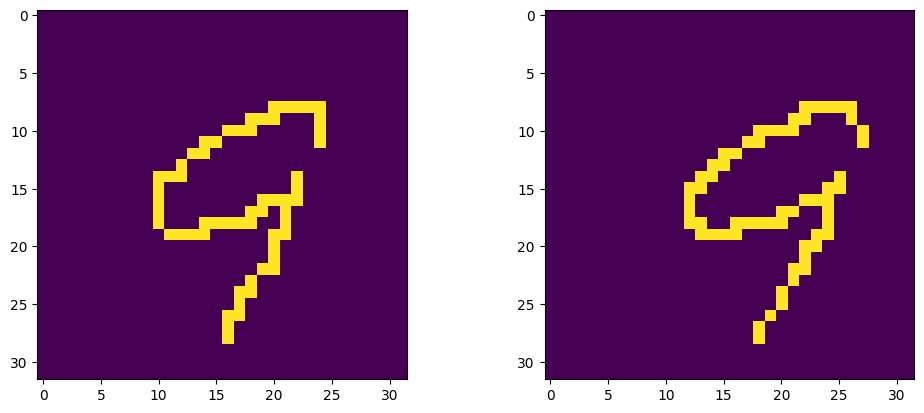

In [33]:
signal_ind = RNG.choice(signals_input.shape[0])
signal_input = xp_array_from_gpu(signals_input[signal_ind])
signal_output = signals_output[signal_ind]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.imshow(signal_input.reshape(32, -1))
ax2.imshow(signal_output.reshape(32, -1));

# Test

In [24]:
# prod_cluster_metas = list(filter(lambda c: c.state == ClusterState.PROD and c.stats[True] > 5, CLUSTER_METAS.values()))
prod_cluster_metas = list(filter(lambda c: c.state == ClusterState.PROD, CLUSTER_METAS.values()))
prod_cluster_inds = np.array(list(map(lambda c: c.cluster_ind, prod_cluster_metas)), dtype='i')
prod_cluster_ones_counts = xp.array(list(map(lambda c: c.ones_count, prod_cluster_metas)), dtype='f')
prod_cluster_output_bits = np.array(list(map(lambda c: c.output_bit, prod_cluster_metas)), dtype='i')
prod_clusters = CLUSTERS.array_active[prod_cluster_inds]
prod_clusters.shape

(1127, 1024)

In [44]:
inspected_ind = 0
cluster_ind = prod_cluster_inds[inspected_ind]
get_cluster_logic(cluster_ind), vars(CLUSTER_METAS[cluster_ind])

(([(22, 18), (23, 18)], (25, 18)),
 {'state': <ClusterState.PROD: 'prod'>,
  'cluster_ind': 2,
  'cluster_key': (601, (361, 434, 595, 598, 599, 657, 753)),
  'output_bit': 601,
  'nu': np.float32(0.14285715),
  'cycle': 0,
  'ones_count': 2,
  'signals_processed': 56,
  'stats': Counter({True: 11}),
  'verify_image_ids': {47014: True,
   14352: True,
   36824: True,
   5295: True,
   46041: True,
   42784: True,
   49595: True,
   12614: True,
   30822: True,
   11357: True,
   17629: True}})

In [84]:
np.unique_counts(seq_bv_out.get())

UniqueCountsResult(values=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
      dtype=float32), counts=array([949,  23,  14,  11,   8,   4,   5,   2,   1,   3,   2,   2]))

In [76]:
get_cluster_logic(prod_cluster_inds[4])

([(13, 22), (14, 22)], (16, 22))

In [86]:
for ind in np.argwhere(activated_clusters_mask).ravel():
    cl = get_cluster_logic(prod_cluster_inds[ind])

    if cl[1][1] == 16 and cl[1][0] < 15:
        print(ind, cl, np.argwhere(CLUSTERS.array_active[prod_cluster_inds[3697]]))

3697 ([(12, 9), (11, 11), (24, 15)], (12, 16)) [[300]
 [363]
 [504]]


In [88]:
seq_bv[[300, 363, 504]]

array([1., 1., 1.], dtype=float32)

CPU times: user 179 ms, sys: 2.8 ms, total: 182 ms
Wall time: 21.5 ms


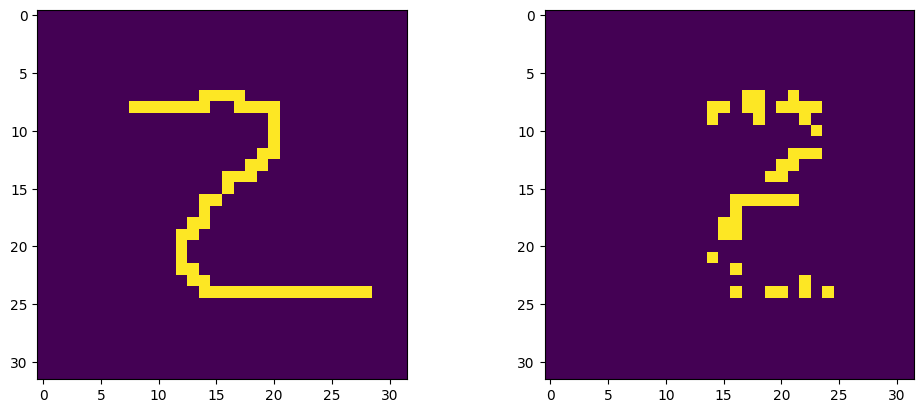

In [25]:
%%time
image_id = RNG.choice(df_train_images.index)
image = next(df_train_images.loc[[image_id]].itertuples())
si_ind_dict = pickle.loads(image.inner_si_ind_dict)
sequences = pickle.loads(image.inner_sequences)
seq_reading_code = tuple(zip(range(len(sequences)), (0,) * len(sequences)))
seq_reading = get_sequences_reading(sequences, seq_reading_code)
seq_ipxy = calc_seq_ipxy(seq_reading, si_ind_dict)
seq_bv = calc_seq_bv(seq_ipxy)

activated_clusters_mask = (prod_clusters @ seq_bv) >= prod_cluster_ones_counts
activated_clusters_mask = xp_array_from_gpu(activated_clusters_mask)
seq_bv_out = np.zeros_like(seq_bv)
# seq_bv_out[prod_cluster_output_bits[activated_clusters_mask]] = 1
values = Counter(prod_cluster_output_bits[activated_clusters_mask])
seq_bv_out[list(values.keys())] = list(values.values())
seq_bv_out = xp.where(seq_bv_out > seq_bv_out.mean(), 1, 0)
# seq_bv_out = xp.where(seq_bv_out > np.median(seq_bv_out), 1, 0)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.imshow(xp_array_from_gpu(seq_bv).reshape(32, -1))
ax2.imshow(xp_array_from_gpu(seq_bv_out).reshape(32, -1));